# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요


생활가전 A부서는 친환경 미니 세탁기를 개발 중에 있다. 

프로젝트의 핵심은 세탁물을 자동 인식하고 이에 따른 최적 코스를 (수량, 수온, 세제종류, 세제량, 세탁시간, 세탁방법) 제시하여 세탁지수(target)를 높이는 것이다. 

이를 위해 세탁지수에 영향을 주는 빨랫감의 종류와 오염량, 급수량, 세제종류, 투입량 등을 측정한 데이터를 확보하였다. 

데이터의 변수명은 보안을 위해 cat0, cont0등으로 코드화 되어 있다.

아래 데이터를 사용하여 과제를 해결하고 세탁지수(target)를 예측하시오.

데이터 구성

학습데이터: train_prob.csv, 240,000 rows, 26 columns

테스트데이터: test_prob.csv, 60,000 rows, 25 columns

테스트정답셋: test_prob_ans.csv, 60,000 rows, 1 columns

|변수명|설명|타입|
|------|----|----|
|Id|실험 고유 번호|정수형|
|cat0 ~ cat9|범주형 변수 0~9|문자형|
|cont0 ~ cont13|연속형 변수 0~13|실수형|
|target|세탁지수|실수형|


# 전처리(Preprocessing)

train_prob.csv 데이터셋을 대상으로 다음 전처리를 진행하라.

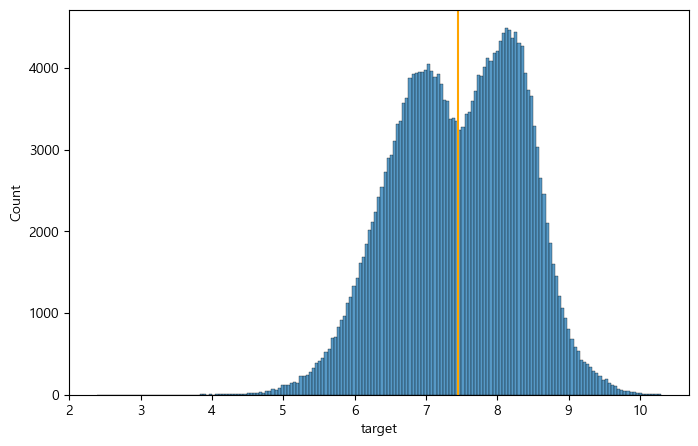

In [3]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
# target의 히스토그램 출력 및 구분선 출력 
plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='target')
plt.axvline(7.45, c='orange')
plt.show()

## 단계 1

target은 2개의 정규 분포가 합쳐진 모양을 하고 있다. 

두 분포의 구분점 7.45를 기준으로 target값이 작거나 같으면 A, 초과하면 B로 나눈다.

A 범주이면 True, B이면 False인 파생 변수 targetA를 만든다.

In [4]:
# 데이터를 불러 옵니다.
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.22443,0.69220,0.30912,0.47134,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741
410037,A,A,A,A,B,B,A,E,C,F,...,0.43278,0.97199,0.62596,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427
139373,A,A,B,A,B,B,A,E,C,J,...,0.36238,0.41310,0.27010,0.40112,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022
113765,A,A,A,C,B,B,A,E,C,G,...,0.32670,0.42301,0.28331,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085
179915,A,B,A,C,B,B,A,E,E,L,...,0.20121,0.37466,0.46316,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448


In [5]:
df_train['targetA'] = df_train['target'] <= 7.45
df_train['targetA'].value_counts()

False    123538
True     116462
Name: targetA, dtype: int64

## 단계 2

cat3 ~ 9 각각의 범주 중에서 빈도가 적은 범주를 target을 예측하는데 영향이 없는 방향으로 정리하려고 한다. 

아래 가이드에 맞추어 cat3 ~ 9 에 대한 전처리를 수행한다.

* cat3는 B→C 로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|
|-|-|-|
|83,634|147,361|9,005|

* cat4는 A→B, D→B 로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|C|
|-|-|
|239,397|603|

* cat6는 D→A, E→B, G→C, H→B, I→A로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|C|
|-|-|-|
|234,203|5,145|652|

* cat7는 A→B, C→B, F→D, I→B로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|D|E|G|
|-|-|-|-|
|4,606|19,784|214,027|1,583|

* cat8는 B→G, F→E로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|E|G|
|-|-|-|-|-|
|30,338|96,743|2,953|76,085|33,881|

* cat9는 C→H, D→B, E→L로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|F|G|H|I|J|K|L|M|N|O|
|-|-|-|-|-|-|-|-|-|-|-|-|
|10,678|2,846|85,944|8,320|19,987|40,070|5,501|16,743|33,793|7,819|3,331|4,968|


In [6]:
# 내용만 바뀌는 반복적인 과정입니다.
# 하나의 단계만 수행해보고 이에 맞춰 나머지는 루프로 처리해봅니다.
df_train['cat3'] = df_train['cat3'].replace({'B': 'C'}) # replace: dict형식을 받으면 key → value 인 치환작업을 진행합니다.
(df_train['cat3'].value_counts().sort_index() != [83634, 147361, 9005]).sum() == 0

True

In [7]:
# 반복적인 과정은 반복화하여 발생할 수 있는 문제를 최소화 해봅니다.
# 로직에 들어갈 내용을 정리해 봅니다.
repl_list= [
    ('cat4', {'A': 'B', 'D': 'B'}, [239397, 603]),
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}, [234203, 5145, 652]),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}, [4606, 19784, 214027, 1583]),
    ('cat8', {'B': 'G', 'F': 'E'}, [30338, 96743, 2953, 76085, 33881]),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'}, [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968]),
]

In [8]:
# 반복문을 통한 치환 작업을 수행합니다.
for c, d, cnt in repl_list:
    df_train[c] = df_train[c].replace(d)
    if (df_train[c].value_counts().sort_index() != cnt).sum() != 0: # 실행 결과를 체크합니다.
        print('error: {}, {}, {}'.format(c, d, df_train[c].value_counts().sort_index(), cnt))
        break
    print(c, d, cnt)

cat4 {'A': 'B', 'D': 'B'} [239397, 603]
cat6 {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'} [234203, 5145, 652]
cat7 {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'} [4606, 19784, 214027, 1583]
cat8 {'B': 'G', 'F': 'E'} [30338, 96743, 2953, 76085, 33881]
cat9 {'C': 'H', 'D': 'B', 'E': 'L'} [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968]


**pandas DataFrame 수정시 주의 사항 입니다**

 얕은 복사 만들어진 DataFrame, Series의 내용을 변경할 경우에는 
 
 그들의 내용은 원본 DataFrame 또는 Series의 Reference를 변경하는 것이라,
 
 이 경우에는 얕은 복사로 만들어진 프레임 상에서의 변경이 예상치 못하는 
 
 결과를 야기할 수 있다고 합니다.
 
 이와 관련된 경고가 발생하게 되는데요. 
 
 아래 로직은 df_train_prob['cat3'][df_train_prob['cat3'] == 3] 그 다음 필터를 통해 얕은 복사를 통해 Series가 만들어집니다.
 
 이 때 수정을 하게 되면 해당 경고가 뜨게 됩니다.
```python
df_train_prob = df_train.copy()
df_train_prob['cat3'][df_train_prob['cat3'] == 'B'] = 'C'
```
 위 구문을 아래와 같이 얕은 복사의 과정을 거치지 않게 하면 문제의 여지를 주지 않고,
 
 변경 작업을 수행할 수 있게 됩니다.
```python
df_train_prob.loc[df_train_prob['cat3'] == 'B', 'cat3'] = 'C'
```

In [10]:
df_basetable = df_train.copy()

전처리 후의 데이터프레임을 basetable이라 한다.

# 문제1

범주형 변수의 조합의 특성을 파악하고자 한다. 다음 과정을 수행하라.

## 단계 1-1

basetable을 복사하여 prob1을 만들고 cat0 ~ 9 변수 순서대로 문자열 결합하여, 10자리 문자형 파생 변수(cat_c)를 생성하라.

In [16]:
df_prob1= df_basetable.assign(
        cat_c=df_basetable[['cat{}'.format(i) for i in range(10)]].apply(lambda x: ''.join(list(x)), axis=1)
)
# str accessor의  cat을 이용한 방법입니다.
#df_basetable[['cat{}'.format(i) for i in range(10)]].apply(lambda x: x.str.cat(), axis=1)

## 단계 1-2

50개 이상 행으로 이루지고, target에 대한 정규성을 부정할 수 없는 cat_c를 찾아 cat_c_A와 cat_c_B를 구하라. 

정규성 검정은 Kolmogolov-Smironov 검정을 사용한다. (유의 수준: 5%)

- cat_c의 행의 개수가 많은 순으로 cat_c 3개를 cat_c_A

- cat_c의 행의 개수가 적은 순으로 cat_c 3개를 cat_c_B

* 행의 개수가 같을 경우에는 p-value가 높은 순으로 고른다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---


In [28]:
from scipy.stats import kstest, norm
# norm의 함수들의 세팅은 표준정규분포로 되어 있습니다.
# kstest를 통한 정규성 검정시에는 입력 샘플은 이 때문에 표준화를 해주어야 합니다.
# 표본을 대상으로 진행하는 것이니 표준화시에는 표본표준편차를 하는 것이 맞다고 판단됩니다.
# pandas에서 제공하는 함수들은 표본(표준편차/분산)을 사용합니다.
# groupby ~ filter를 통해 cat_c가 50개 이상의 행을 지닌 cat_c으 데이터만 뽑아냅니다.
# groupby ~ apply를 통해 cat_c 별 kstest를 수행합니다.
# pd.Series로 검정 결과를 넘겨 줍니다. 
# unstack을 통해 stat, pvalue을 컬럼 영역으로 매칭시킵니다 
# cat_c의 빈도수를 구해 결합합니다.
df_kstest = df_prob1.groupby('cat_c').filter(lambda x: len(x) >= 50)\
        .groupby('cat_c')['target'].apply(
            lambda x: pd.Series(kstest((x - x.mean()) / x.std(), norm.cdf), index=['stat', 'pvalue'])
        ).unstack().join(df_prob1['cat_c'].value_counts().rename('cnt'))
df_kstest

,stat,pvalue,cnt
cat_c,,,
AAAABBADAF,0.093664,0.548731,69
AAAABBADCF,0.075332,0.100458,259
AAAABBADCI,0.084878,0.705019,65
AAAABBADEF,0.093602,0.586496,65
AAAABBAEAA,0.051012,0.922963,110
...,...,...,...
BBACBDAECF,0.075426,0.611944,97
BBACBDAEEF,0.085839,0.583426,78
BBACBDAEEI,0.107658,0.490084,57


In [64]:
# 검정 결과에서 정규성을 부정할 수 없는 것을 뽑고
# 빈도수가 높은 cat_c에는 동일한 빈도는 없지만, 
# 낮은 것에서는 빈도가 동일한 것이 존재합니다.
# 요건에서는 동일할 경우 pvalue가 높은 것을 뽑으라고 했으니
# cnt는 내림차순으로 pvalue는 오름차순으로 하여
# cat_c_A, cat_c_B를 취하도록합니다
df_kstest = df_kstest.query('pvalue >= 0.05')\
                    .sort_values(['cnt', 'pvalue'], ascending=[False, True])
df_kstest

,stat,pvalue,cnt
cat_c,,,
ABACBBAEEI,0.030799,0.054494,1888
AAAABBAEEI,0.040326,0.099566,914
AAACBDAEGI,0.044676,0.057831,880
AAACBBAEEA,0.045374,0.066533,819
AAACBBAEEH,0.036724,0.216905,814
...,...,...,...
ABBCBDAEEM,0.077785,0.899734,50
AAACBCAEEI,0.071563,0.943845,50
ABADBDAEAL,0.067553,0.964781,50


In [35]:
cat_c_A = df_kstest.iloc[:3].index.tolist()
cat_c_B = df_kstest.iloc[-3:].index.tolist()
cat_c_A, cat_c_B

(['ABACBBAEEI', 'AAAABBAEEI', 'AAACBDAEGI'],
 ['ABADBDAEAL', 'BBAABDAEEF', 'ABBABBAECI'])

**참고**

sklearn.preprocessing.StandardScaler에서 표준편차는 모표준편차를 사용하고 있습니다.

StandardScaler 가이드 발췌
```
We use a biased estimator for the standard deviation, equivalent to
`numpy.std(x, ddof=0)`. Note that the choice of `ddof` is unlikely to
affect model performance
```

## 단계 1-3

bartlett 검정을 사용하여 cat_c_A에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 A라 한다. 

그리고 bartlett 검정을 사용하여 cat_c_B에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 B라고 한다. 


---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [40]:
from scipy.stats import bartlett

result_1_3_1 = bartlett(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_A)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
A = result_1_3_1.statistic

result_1_3_2 = bartlett(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
B = result_1_3_2.statistic

result_1_3_1, A, result_1_3_2, B

(BartlettResult(statistic=9.478560380242815, pvalue=0.00874493861372744),
 9.478560380242815,
 BartlettResult(statistic=0.4140582984181041, pvalue=0.8129959514532286),
 0.4140582984181041)

## 단계 1-4

등분산성을 부정할 수 없는 경우는 경우는 단 하나 있다.

이 경우에 해당하는 행들을 대상으로 해당 범주 3개에 대한 분산분석(ANOVA)를 수행하고 p-value를 C라고 한다. 

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [43]:
from scipy.stats import f_oneway
result_1_4 = f_oneway(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
C = result_1_4.pvalue
result_1_4, C

(F_onewayResult(statistic=0.1660465473994472, pvalue=0.8471654486810101),
 0.8471654486810101)

In [44]:
A, B, C, A + B + C

(9.478560380242815, 0.4140582984181041, 0.8471654486810101, 10.739784127341927)

A + B + C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 표시하라.

**10.740**

**Python에서의 반올림**

오사오입법: 반올림 대상이 5일 경우, 반올림 이전 자리 숫자가 홀수이면 버리고, 짝수 이면 올려주는 방법입니다.

[반올림](https://ko.wikipedia.org/wiki/%EB%B0%98%EC%98%AC%EB%A6%BC#%EC%98%A4%EC%82%AC%EC%98%A4%EC%9E%85)

```python
round(0.125, 2), round(0.135, 2)
```
Output: 0.12, 0.14

Print에서도 동일하게 적용됩니다됩니다.
```python
print(f"{0.125:.2f} {0.135:.2f}")
```
Output: 0.12, 0.14

# 문제 2

연속형 변수 cont0 ~ 13 중에서, 서로 피어슨 상관도(Pearson correlation)가 높은 변수들 찾고, 

이들을 PCA를 통한 차원 축소를 하여 성능 향상이 있는지 확인하고자 한다.

## 단계 2-1

basetable 에서 인덱스와 컬럼 모두 cont0 ~ 13이고, 

인덱스와 컬럼에 해당하는 변수 간에 피어슨 상관도(Pearson correlation)를 값으로 하는 대각 대칭형인 데이터프레임을 corr을 만든다.

In [66]:
corr_cols = ['cont{}'.format(i) for i in range(14)]
# pandas.DataFrame.corr을 통해 상관도 Matrix를 구합니다.
df_corr = df_basetable[corr_cols].corr()
df_corr

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
cont0,1.000000,-0.123344,-0.268621,0.255262,-0.108197,0.573894,0.301672,0.300353,0.579618,0.524481,0.394401,0.425350,0.473249,0.039613
cont1,-0.123344,1.000000,0.174625,-0.153110,-0.035455,-0.064297,0.099449,-0.091482,-0.105811,-0.035944,0.070926,0.060877,-0.080143,-0.034036
cont2,-0.268621,0.174625,1.000000,-0.216238,0.047065,-0.291732,-0.050488,-0.213688,-0.278496,-0.227655,-0.071688,-0.107875,-0.329195,-0.054582
cont3,0.255262,-0.153110,-0.216238,1.000000,-0.048677,0.253592,0.059515,0.215057,0.264717,0.220375,0.099694,0.131967,0.253720,0.043121
cont4,-0.108197,-0.035455,0.047065,-0.048677,1.000000,-0.166160,-0.175280,-0.105320,-0.136829,-0.150984,-0.187024,-0.199560,-0.127953,-0.012127
cont5,0.573894,-0.064297,-0.291732,0.253592,-0.166160,1.000000,0.341552,0.341689,0.606329,0.615449,0.482025,0.509316,0.631540,0.029530
cont6,0.301672,0.099449,-0.050488,0.059515,-0.175280,0.341552,1.000000,0.151666,0.307044,0.381141,0.455662,0.485435,0.246285,0.037730
cont7,0.300353,-0.091482,-0.213688,0.215057,-0.105320,0.341689,0.151666,1.000000,0.334679,0.283921,0.200623,0.228630,0.337916,0.049162
cont8,0.579618,-0.105811,-0.278496,0.264717,-0.136829,0.606329,0.307044,0.334679,1.000000,0.558560,0.413619,0.458089,0.530215,0.047070
cont9,0.524481,-0.035944,-0.227655,0.220375,-0.150984,0.615449,0.381141,0.283921,0.558560,1.000000,0.484661,0.529252,0.538278,0.000957


## 단계 2-2

계층적 군집화를 활용하여 다음 개념도(실제 결과와는 상관 없음)와 같이 연관성이 높은 변수 군집을 찾아 보고자 한다. 

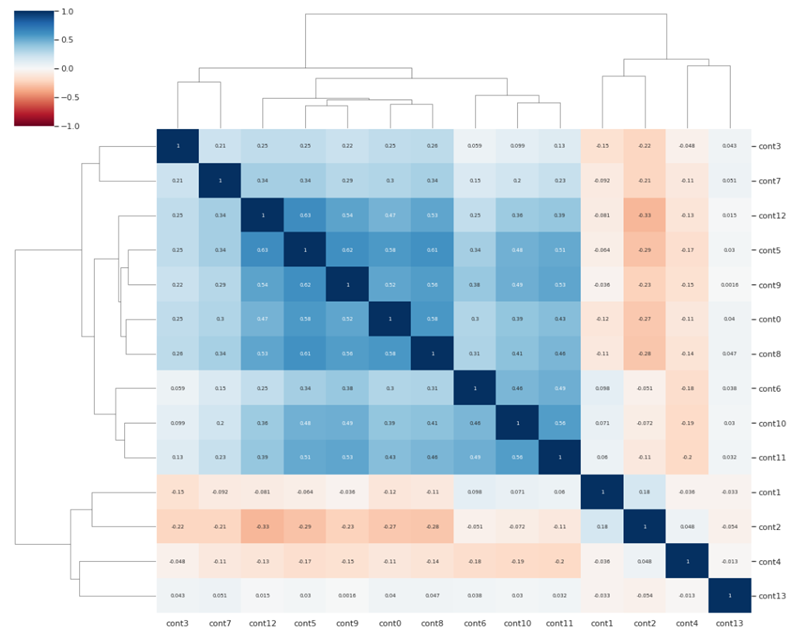

초기에는 cont0~13 변수 각각을 하나의 군집으로 배정한 상태에서 시작하여, 

군집 간 결합 조건으로 두 군집에 포함된 변수간의 피어슨 상관도 절대값의 평균이 0.5이상 일 때, 

해당 수치가 높은 것을 우선으로 군집들을 결합한다. 군집의 크기가 가장 큰 변수들을 구하라.


Hint] cont0 ~ 13간의 거리는 [단계 2-1] corr을 이용하여 군집 결합 조건을 고려하여 구한다. 

    (두 변수간에 피어슨 상관도의 절대값이 높을 수록 거리는 가깝다.)

---
**함수가이드**

sklearn.cluster.AgglomerativeClustering

문제 지시사항 외 Default 값 사용

---

```python
# 차트 출력 코드입니다.
plt.figure(figsize=(12, 7))
sns.set(font_scale=1)
cont_cols = ['cont{}'.format(i) for i in range(14)]
sns.clustermap(df_train[cont_cols].corr(), method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));
plt.show()
```

In [78]:
# abs를 통해 클 수록 상관도 높게 만들고
# 상관도가 높을 수록 거리가 가깝다고 할 수 있으니,
# -를 통해 상관도를 거리의 개념으로 바꾸어 줍니다
# 1을 추가하여 -1~0을 0~1로 바꾸어,
# 절대값의 평균 0.5라는 조건을 적용하기 쉽고 
# 음수인 거리로 인해 발생할 수 있는 이슈도 막아줍니다.
df_dist = 1 - abs(df_corr)

In [80]:
from sklearn.cluster import AgglomerativeClustering
clu_agg = AgglomerativeClustering(
    n_clusters=None, # 군집의 수는 distance_threshold로 정합니다
    affinity='precomputed', # 상위 버젼 metric='precomputed'
    linkage='average', # 결합의 기준을 군집간의 거리의 평균으로 합니다 - '절대값의 평균이 0.5'에서 '평균' 반영
    distance_threshold=0.5 # 결합 기준점을 0.5로 합니다. - '절대값의 평균이 0.5'에서 0.5를 반영합니다
)
clu_agg.fit(df_dist)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.5,
                        linkage='average', memory=None, n_clusters=None,
                        pooling_func='deprecated')

In [82]:
clu_agg.labels_

array([0, 5, 6, 4, 7, 0, 8, 2, 0, 0, 1, 1, 0, 3], dtype=int64)

In [85]:
X_corr = list(np.array(corr_cols)[clu_agg.labels_ == 0])
X_corr

['cont0', 'cont5', 'cont8', 'cont9', 'cont12']

## 단계 2-3

basetable에서 cat0 ~ 9을 각 변수의 첫 번째 범주(알파벳 순)를 제외하고 원핫 인코딩(One-hot encoding)하여 prob2를 만든다.

In [107]:
# drop_first는 알파벳순으로 범주값들을 나열했을 때 첫번째에 해당하는 범주값을 제외하고, 가변수화 하게 합니다.
df_prob2 = pd.get_dummies(df_basetable, columns=['cat{}'.format(i) for i in range(10)], drop_first=True)
df_prob2.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
267387,0.65226,0.55771,0.25398,0.28196,0.82400,0.22443,0.69220,0.30912,0.47134,0.53290,...,0,1,0,0,0,0,0,0,0,0
410037,0.36970,0.68159,0.30038,0.20156,0.46113,0.43278,0.97199,0.62596,0.40193,0.49181,...,1,0,0,0,0,0,0,0,0,0
139373,0.47881,0.63976,0.40024,0.24153,0.27128,0.36238,0.41310,0.27010,0.40112,0.53052,...,0,0,0,0,1,0,0,0,0,0
113765,0.43438,0.77575,0.54887,0.21935,0.27944,0.32670,0.42301,0.28331,0.46425,0.38302,...,0,1,0,0,0,0,0,0,0,0
179915,0.47866,0.64326,0.37255,0.21004,0.41188,0.20121,0.37466,0.46316,0.75578,0.55676,...,0,0,0,0,0,0,1,0,0,0


## 단계 2-4

prob2에서 80%는 학습용 prob2_train으로 20%는 테스트용 prob2_test으로 분리한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [108]:
from sklearn.model_selection import train_test_split
df_prob2_train, df_prob2_test = train_test_split(df_prob2, train_size=0.8, random_state=123)
df_prob2_train, df_prob2_test = df_prob2_train.copy(), df_prob2_test.copy()
df_prob2_train.shape, df_prob2_test.shape

((192000, 46), (48000, 46))

## 단계 2-5

prob2_train으로 [단계 2-2]에서 도출된 변수들로 PCA 모델을 만들고 

분산 설명률이 높은 순으로 누적 분산 설명률이 0.8을 넘기는 최소의 컴포넌트를 prob2_train에 추가 한다. 

동일한 PCA 모델로 prob2_test를 변환하여 같은 수의 컴포넌트를 prob2_test에 추가 한다.

---
**함수가이드**

sklearn.decomposition.PCA (입력의 순서는 cont 뒤의 번호가 낮은 것에서 높은 것 순으로 한다, random_state=123)

문제 지시사항 외 Default 값 사용

----

In [95]:
from sklearn.decomposition import PCA
# n_components=0.8 적어도 80% 분산을 설명할 수 있는 최소의 컴포넌트를 취합니다
pca = PCA(n_components=0.8)
df_prob2_train[['pca_{}'.format(i) for i in range(3)]] = \
        pd.DataFrame(pca.fit_transform(df_prob2_train[X_corr]), index=df_prob2_train.index)
df_prob2_test[['pca_{}'.format(i) for i in range(3)]] = \
        pd.DataFrame(pca.transform(df_prob2_test[X_corr]), index=df_prob2_test.index)

## 단계 2-6

prob2_train에서 target을 선형회귀모델로 학습하고 prob2_test를 다음 성능 지표로 평가한 값을 A라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
Hint] 학습데이터의 형태는 (192,000, 43) 이다. 

---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_cont = ['cont{}'.format(i) for i in range(14)]
X_cat = [i for i in df_prob2_train.columns if i.startswith('cat') and i != 'cat_c']
X_lr = X_cont + X_cat
reg_lr = LinearRegression()
reg_lr.fit(df_prob2_train[X_lr], df_prob2_train['target'])
mean_squared_error(df_prob2_train['target'], reg_lr.predict(df_prob2_train[X_lr]))

0.7446868277591954

In [101]:
A = mean_squared_error(df_prob2_test['target'], reg_lr.predict(df_prob2_test[X_lr]))
A

0.7455022756348629

## 단계 2-7

prob2_train에서 cont0 ~ 13 중에서 PCA에서 사용했던 변수를 제외하고 

단계 2-5에서 추가한 PCA 컴포넌트를 포함하여 target로 선형회귀모델을 학습한다. 

prob2_test로 동일한 지표로 대한 성능 평가한 값을 B라 한다.


입력변수: cont0 ~ 13중 PCA에 사용한 것을 제외한 나머지 변수, 

PCA를 통한 파생 변수를 분산 설명력이 높은 순으로, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_cont = ['cont{}'.format(i) for i in range(14)]
X_cont = [i for i in X_cont if i not in X_corr] + ['pca_0', 'pca_1', 'pca_2']
X_cat = [i for i in df_prob2_train.columns if i.startswith('cat') and i != 'cat_c']
X_lr = X_cont + X_cat
reg_lr = LinearRegression()
reg_lr.fit(df_prob2_train[X_lr], df_prob2_train['target'])
mean_squared_error(df_prob2_train['target'], reg_lr.predict(df_prob2_train[X_lr]))

0.7487486877700789

In [105]:
B = mean_squared_error(df_prob2_test['target'], reg_lr.predict(df_prob2_test[X_lr]))
B

0.7499049886498875

In [106]:
A - B

-0.004402713015024595

A-B 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 구하라.

**-0.004**

# 문제3

전처리 단계에서 target이 두 개의 정규 분포의 혼합한 형태 보이고 있음 확인했고, 

target을 7.45 경계값을 기준으로 A와 B범주로 나누었다. 

Gaussian Mixture라는 모델을 사용하여 두 개 정규 분포의 매개 변수를 측정했고, target의 분포를 시각화했다. 

아래 시각화 그래프에서 A, B가 혼재하여 A 또는 B라고 확신할 수는 없는 구간이 존재한다. 

확률을 기반으로, A 또는 B라고 확신할 수 있는 관측치만을 가지고 A / B를 분류 모델을 만들고자 한다. 다음 단계들을 수행하라.

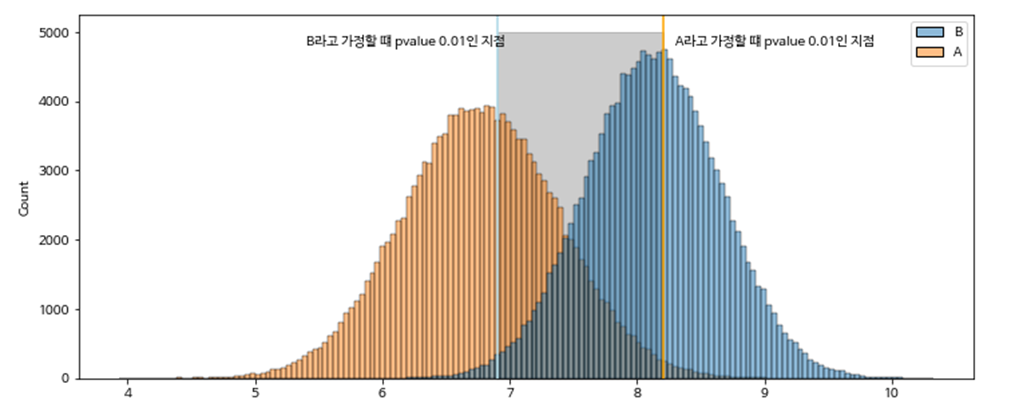

그래프 출력용 코드입니다.
```python
plt.figure(figsize=(12, 5))
X, y = gmm.sample(300000)
sns.histplot(x=X[:,0], hue=np.where(y== 0, 'B', 'A'))
pos_A = norm.ppf(0.99, loc=mu_A, scale=std_A)
pos_B = norm.ppf(0.01, loc=mu_B, scale=std_B)
plt.gca().axvline(pos_A, c='orange')
plt.gca().annotate("A라고 가정할 떄 pvalue 0.01인 지점", (pos_A + 0.1, 4800))
plt.gca().fill_between([pos_A, pos_B], y1=0, y2=5000, alpha=0.2, color='black')
plt.gca().axvline(pos_B, c='lightblue')
plt.gca().annotate("B라고 가정할 떄 pvalue 0.01인 지점", (pos_B - 1.5, 4800))
plt.show()
```

## 단계 3-1

A 범주의 평균은 6.769 표준편차는 0.616이고 범주 B일 때 평균은 8.123 표준편차는 0.527이다. 

측정한 값을 범주A, B의 모집단의 target의 평균과 표준편차라고 가정한다. 

두 개의 정규 분포를 이용하여, 귀무가설이 ‘target은 A 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_A)를 만들다. 

반대로, 귀무가설이 ‘target은 B 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_B)를 만든다.

basetable에 두 개의 파생 변수 prob_A, prob_B를 추가하여 prob3 데이터프레임을 만든다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [114]:
from scipy.stats import norm
# 모집단의 통계라고 주어진 값을 선언합니다.
mu_A, std_A = 6.769, 0.616
mu_B, std_B = 8.123, 0.527
df_prob3 = df_basetable.assign(
    prob_A = 1 - norm.cdf(df_basetable['target'], loc=mu_A, scale=std_A), # A의 분포에서, 우측 꼬리에 해당하는 영역을 구합니다.
    prob_B =norm.cdf(df_basetable['target'], loc=mu_B, scale=std_B) # B의 분포에서, 좌측 꼬리에 해당하는 영역을 구합니다.
)
df_prob3.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont9,cont10,cont11,cont12,cont13,target,targetA,cat_c,prob_A,prob_B
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741,False,ABBCBBAEGG,0.013160,0.510907
410037,A,A,A,A,B,B,A,E,C,F,...,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427,True,AAAABBAECF,0.151204,0.086313
139373,A,A,B,A,B,B,A,E,C,J,...,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022,False,AABABBAECJ,0.024634,0.393223
113765,A,A,A,C,B,B,A,E,C,G,...,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085,True,AAACBBAECG,0.212302,0.050924
179915,A,B,A,C,B,B,A,E,E,L,...,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448,True,ABACBBAEEL,0.210597,0.051649


## 단계 3-2

prob3 중에서 target이 A 또는 B라고 신뢰할 수 있는 행들만을 골라내고자 한다.

prob_B가 0.01 미만이거나, prob_A가 0.01 미만인 것만 남긴다. (즉, 위 그림에서 회색 영역에 해당하는 부분은 제외)

Hint] 행의 개수는 124,600가 된다.

In [117]:
df_prob3 = df_prob3.query('prob_B < 0.01 or prob_A < 0.01').copy()
df_prob3.shape

(124600, 29)

In [118]:
# 참고용 코드입니다
# pvalue가 0.01인 지점을 기준으로 구합니다.
# 누적확률함수의 역함수 ppf를 이용하면 해당 지점을 구할 수 있습니다.
# 우측 1% 꼬리 영역은 좌측을 기준으로 99%인 지점이라, 0.99로 세팅한 것입니다.
df_basetable.loc[
    (df_basetable['target'] > norm.ppf(0.99, loc=mu_A, scale=std_A)) |
    (df_basetable['target'] < norm.ppf(0.01, loc=mu_B, scale=std_B))
]

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,targetA,cat_c
id,,,,,,,,,,,,,,,,,,,,,
29503,A,B,A,C,B,B,A,E,E,F,...,0.28413,0.30163,0.32551,0.26982,0.19329,0.39034,0.30002,6.66255,True,ABACBBAEEF
113326,A,B,A,A,B,D,A,E,C,H,...,0.57879,0.65004,0.63958,0.60535,0.70951,0.71664,0.78782,5.98141,True,ABAABDAECH
199507,A,B,B,A,B,B,A,E,A,L,...,0.23057,0.22571,0.48717,0.33999,0.51461,0.37367,0.69462,6.60870,True,ABBABBAEAL
346281,A,A,A,D,B,D,A,E,C,F,...,0.35212,0.45999,0.79100,0.62269,0.83624,0.78785,0.30893,5.42339,True,AAADBDAECF
137333,A,A,A,C,B,D,A,D,C,K,...,0.34923,0.49416,0.89742,0.59422,0.72298,0.72535,0.82115,8.34177,False,AAACBDADCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76711,A,B,A,C,B,D,A,D,E,F,...,0.25656,0.85100,0.26369,0.24340,0.22768,0.83386,0.49068,8.42823,False,ABACBDADEF
215151,A,B,B,C,B,B,A,E,E,F,...,0.29387,0.31602,0.55754,0.76485,0.80875,0.28582,0.74923,8.78659,False,ABBCBBAEEF
244056,A,B,A,C,B,B,A,E,E,F,...,0.47919,0.33881,0.40674,0.24883,0.20810,0.55646,0.29033,8.54518,False,ABACBBAEEF


## 단계 3-3

prob3에 cat0 ~ 9를 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 한다. 


In [127]:
from sklearn.preprocessing import OneHotEncoder
# sklearn의 OneHotEncoder를 활용해봅니다.
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_prob3[['cat{}'.format(i) for i in range(10)]])
# 변수명이, x0_..., x1_... 으로 추상화 됩니다. 
# 입력 변수의 순서대로 가변수화 됩니다. cat0->x0, cat1->x1, ...
ohe_cols = ohe.get_feature_names()
df_prob3[ohe_cols] = \
    pd.DataFrame(ohe.transform(df_prob3[['cat{}'.format(i) for i in range(10)]]), index=df_prob3.index)

## 단계 3-4

prob3를 학습용 80%, 그 외 20%는 테스트용으로 나누어 prob3_train, prob3_test로 한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [129]:
from sklearn.model_selection import train_test_split
df_prob3_train, df_prob3_test = train_test_split(df_prob3, train_size=0.8, random_state=123)
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()
df_prob3_train.shape, df_prob3_test.shape

((99680, 68), (24920, 68))

## 단계 3-5

prob3_train으로 target_A를 예측하는 xgboost 분류 모델을 다음과 같은 설정으로 prob3_train를 사용하여 학습한다. 

prob3_test으로 다음 성능지표로 평가한 값을 C 라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9까지 원핫-인코딩 파생 변수 (변수명, 범주순으로 알파벳 순서)

대상변수: targetA

성능지표: $Accuracy(Y, \hat{Y})=\frac{TP+TN}{TP+FP+TN+FN}$

하이퍼 파라미터(Hyper-Parameter, 초매개변수) 설정: 

|항목|값|
|----|--|
|트리의 최대 깊이|2|
|L1 규제|0.1|
|L2 규제|0.1|
|트리 당 컬럼 샘플링 비율|0.25|
|트리의 수|500|
|random_state|123|

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

----


In [134]:
import xgboost as xgb
X_xgb = ['cont{}'.format(i) for i in range(14)] + list(ohe_cols)
clf_xgb = xgb.XGBClassifier(
    max_depth=2, #트리의 최대 깊이: 2
    reg_alpha=0.1, # L1 규제: 0.1
    reg_lambda=0.1, # L2 규제: 0.1
    colsample_bytree=0.25, #트리 당 컬럼 샘플링 비율: 0.25
    n_estimators=500, #트리의 수: 500
    random_state=123
)
clf_xgb.fit(df_prob3_train[X_xgb], df_prob3_train['targetA'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.25, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=123, reg_alpha=0.1,
              reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [137]:
from sklearn.metrics import accuracy_score
# accuracy_score는 출력 label을 비교합니다
# roc_auc_score는 predict_proba로 확률을 예측하여 positive 확률을 넘겼지만,
# accuracy_score는 predict로 예측 label을 넘깁니다.
accuracy_score(df_prob3_train['targetA'], clf_xgb.predict(df_prob3_train[X_xgb]))

0.6661918138041734

In [139]:
C = accuracy_score(df_prob3_test['targetA'], clf_xgb.predict(df_prob3_test[X_xgb]))
C

0.6547351524879614

C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하라.

**0.655**

# 문제 4
 
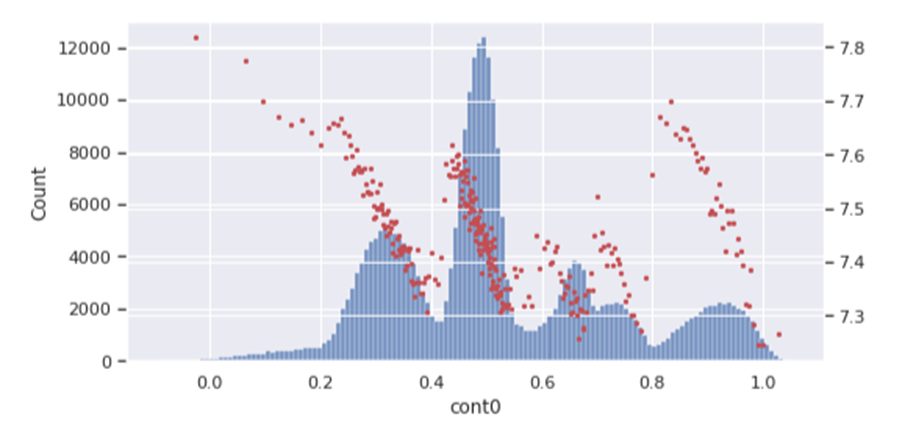

위 차트는 cont0 의 히스토그램과 cont0를 300개의 분위 구간으로 나누어 x값은 분위 구간의 중간값, 

y값은 분위 구간에서 target의 평균을 산포도 그래프로 동시에 출력했다. 

좌측 y축은 히스토그램의 빈도수이고, 우측 y축은 target의 평균이다. 

히스토그램에서 동일한 봉우리 구간 내에서 cont0와 target간에 선형적 관계가 있음이 확인되었다. 

이 점을 이용하여 파생 변수를 만들어서 회귀모델을 만들어 간다.

## 단계 4-1

basetable에서 cat0 ~ 9을 첫 번째 범주(알파벳 순)는 제외하고 원핫 인코딩(One-Hot Encoding)하여 prob4데이터셋을 만든다.

In [141]:
df_prob4 = pd.get_dummies(df_basetable, columns=['cat{}'.format(i) for i in range(10)], drop_first=True)
df_prob4.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
267387,0.65226,0.55771,0.25398,0.28196,0.82400,0.22443,0.69220,0.30912,0.47134,0.53290,...,0,1,0,0,0,0,0,0,0,0
410037,0.36970,0.68159,0.30038,0.20156,0.46113,0.43278,0.97199,0.62596,0.40193,0.49181,...,1,0,0,0,0,0,0,0,0,0
139373,0.47881,0.63976,0.40024,0.24153,0.27128,0.36238,0.41310,0.27010,0.40112,0.53052,...,0,0,0,0,1,0,0,0,0,0
113765,0.43438,0.77575,0.54887,0.21935,0.27944,0.32670,0.42301,0.28331,0.46425,0.38302,...,0,1,0,0,0,0,0,0,0,0
179915,0.47866,0.64326,0.37255,0.21004,0.41188,0.20121,0.37466,0.46316,0.75578,0.55676,...,0,0,0,0,0,0,1,0,0,0


## 단계 4-2

prob4의 80%를 prob4_train으로 20% prob4_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

---

In [142]:
from sklearn.model_selection import train_test_split
df_prob4_train, df_prob4_test = train_test_split(df_prob4, train_size=0.8, random_state=123)
df_prob4_train, df_prob4_test = df_prob4_train.copy(), df_prob4_test.copy()
df_prob4_train.shape, df_prob4_test.shape

((192000, 46), (48000, 46))

## 단계 4-3

prob4_train에서 cont0를 100개의 우측이 닫힌 (ex. i번째 분위수 < cont0 ≤ i+1 번째 분위수) 분위 구간으로 나누고 

각각의 분위 구간에서 target의 평균을 구해 파생 변수 cont0_q를 만든다. 

prob4_test에는 prob4_train을 나누었던 구간과 평균으로 cont0_q를 만든다. 

이 때, prob4_test의 cont0값이 train의 첫 번째 구간보다 작다면, 첫 번째 구간으로 간주하고, 

마지막 구간보가 크다면, 마지막 구간으로 간주한다.

---
**함수가이드**

Hint 1] pandas.Series.quantile, pandas.cut 활용을 권장한다.

Hint 2] 두 번째 분위 구간은 0.111 < cont0 <= 0.176이고 target의 평균은 7.672 (셋째 자리까지 반올림)

Hint 3] cont0_q의 평균은 7.46, 표준 편차는 0.10 (소수점 둘째 자리까지 반올림)

---

In [167]:
q = [i / 100 for i in range(101)] # np.linspace(0, 1, 101)
q_val = df_prob4_train['cont0'].quantile(q)
q_val.iloc[[0, -1]] = [-np.inf, np.inf]
q_int = pd.cut(df_prob4_train['cont0'], q_val)
q_mean = df_prob4_train.groupby(q_int)['target'].mean()
df_prob4_train['cont0_q'] = q_int.map(q_mean).astype('float')
df_prob4_test['cont0_q'] = pd.cut(df_prob4_test['cont0'], q_val).map(q_mean).astype('float')

## 단계 4-4

나머지 변수 cont1~13에 대해서도 해당 작업을 진행한다. 

생성한 파생 변수명은 원래의 변수명에 _q를 결합한다. (ex. cont1 -> cont1_q)

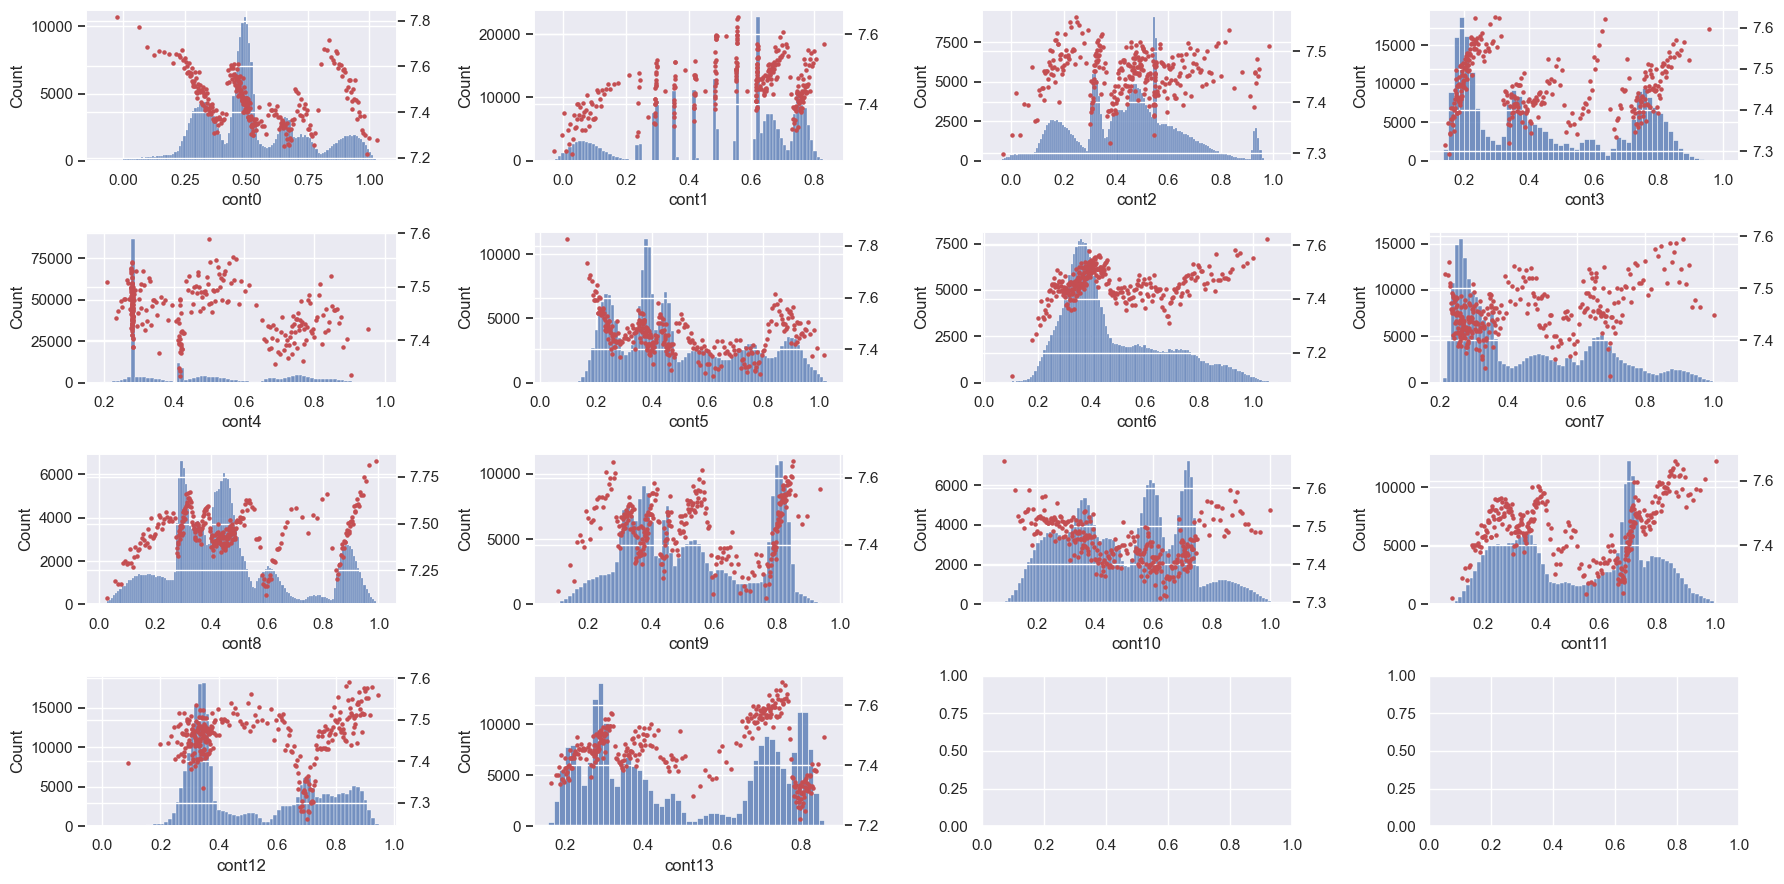

In [176]:
# 다른 변수에 대해서도 그래프를 출력

fig, axes = plt.subplots(4, 4, figsize=(18, 9))
for i, ax in enumerate(axes.ravel()[:14]):
    col = 'cont{}'.format(i)
    sns.histplot(data=df_train, x=col, ax=ax)
    tmp = df_train.groupby(pd.qcut(df_train[col], q=300))[['target']].mean()
    ax.twinx().scatter((tmp.index.categories.left + tmp.index.categories.right) / 2, 
                       tmp['target'], c='r', s=5)
plt.tight_layout()
plt.show()

In [168]:
q = [i / 100 for i in range(101)] # np.linspace(0, 1, 101)
for i in range(1, 14):
    col = 'cont{}'.format(i)
    col_q = col + '_q'
    q_val = df_prob4_train[col].quantile(q)
    q_val.iloc[[0, -1]] = [-np.inf, np.inf]
    q_int = pd.cut(df_prob4_train[col], q_val)
    q_mean = df_prob4_train.groupby(q_int)['target'].mean()
    df_prob4_train[col_q] = q_int.map(q_mean).astype('float')
    df_prob4_test[col_q] = pd.cut(df_prob4_test[col], q_val).map(q_mean).astype('float')

## 단계 4-5

prob4_train에서 target을 대상으로 선형회귀모델을 학습하고, 

prob4_test를 다음 지표로 성능 평가한 값을 D라고 한다. 

선형회귀 모델은 아래와 같은 손실함수로 학습을 한다.

$||Xw - y||^2_2 + \alpha||w||^2_2, \alpha = 0.1$

Hint] sklearn.linear_regression.Ridge 또는 Lasso 중 요건에 맞는 것을 사용한다. 

입력 변수: cont0_q ~ cont13_q, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명 다음 범주명으로 알파벳 순서이다)

대상 변수: target

성능 지표: $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$


In [174]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
X_q = ['cont{}_q'.format(i) for i in range(14)]
X_dum = [i for i in df_prob4_train.columns if i.startswith('cat') and i != 'cat_c']
X_ridge = X_q + X_dum
reg_ridge = Ridge(0.1)
reg_ridge.fit(df_prob4_train[X_ridge], df_prob4_train['target'])
mean_squared_error(df_prob4_train['target'], reg_ridge.predict(df_prob4_train[X_ridge]))

0.7133971363485151

In [175]:
D = mean_squared_error(df_prob4_test['target'], reg_ridge.predict(df_prob4_test[X_ridge]))
D

0.7211658399136691

D를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하라.

**0.72**

# 쉬는 시간: ~ 15:18

# 문제 5


XGBoost 분류 모델의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색한다.

## 단계 5-1

basetable에 cat0 ~ 9 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 하여 prob5를 만든다.


## 단계 5-2

prob5를 80%는 학습용 prob5_train으로, 20%는 테스트용 prob5_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

## 단계 5-3

다음 회귀 분석 모델을 아래 3개의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 사용하여 

prob5_train으로 target를 학습시킨다.

prob5_test으로 테스트했을 때 , 최적의 성능을 낸 하이퍼 파라미터 셋의 번호를 A, 성능지표를 B라고 한다.

입력 변수] cont0~13, cat0 ~ 9을 원핫 인코딩하여 나온 파생 변수(변수명, 범주명 알파벳순)


대상 변수] target


성능 지표] $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
|No|하이퍼 파라미터(Hyper-parameter, 초매개변수)|
|--|--------------------------------------------|
|1|colsample_bytree=0.25, n_estimators=300|
|2|colsample_bytree=0.5, n_estimators=300|
|3|colsample_bytree=0.25, n_estimators=500|

공통적으로 트리의 최대 깊이는 2, 랜덤 시드는 123 이다.

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

A + B 를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

ex) 3.14